<a href="https://colab.research.google.com/github/Irina-Bichik/AB-test/blob/main/Python_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%81%D1%82%D0%B0%D1%82%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B5%D0%B2_%D0%BD%D0%B0_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B5_%D0%BF%D0%B0%D0%B9%D0%BF%D0%BB%D0%B0%D0%B9%D0%BD_%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B8_A_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

In [10]:
df = pd.read_excel('/AB_Test_Results.xlsx')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [11]:
df


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [13]:
df.shape

(10000, 3)

In [14]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [15]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [16]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [17]:
df.USER_ID.nunique()

6324

In [19]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})
df.shape

(7865, 3)

In [20]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

Корректировка данных

In [25]:
unique_ids = \
(df
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )
df_new = df[df.USER_ID.isin(unique_ids)].copy(deep=True)
df_new.shape

(4783, 3)

In [26]:
df_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [40]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

Тест Шапиро-Уилка на соответствие выборки нормальному распределению

In [51]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Выборка имеет {} нормальное рапределение\n'.format( {True: 'не',
False: ''}[st[1] < alpha]));

Выборка имеет не нормальное рапределение



График дохода по пользователям

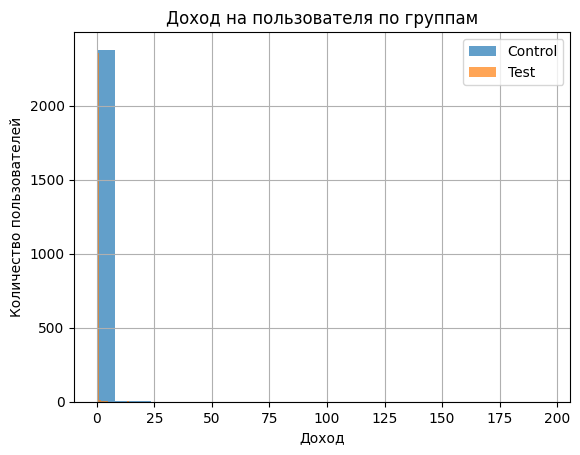

In [52]:
control.REVENUE.hist(bins = 25, alpha = 0.7, label = 'Control')
test.REVENUE.hist(bins = 25, alpha = 0.7, label = 'Test')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend();

In [53]:
mw_stats = scipy.stats.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

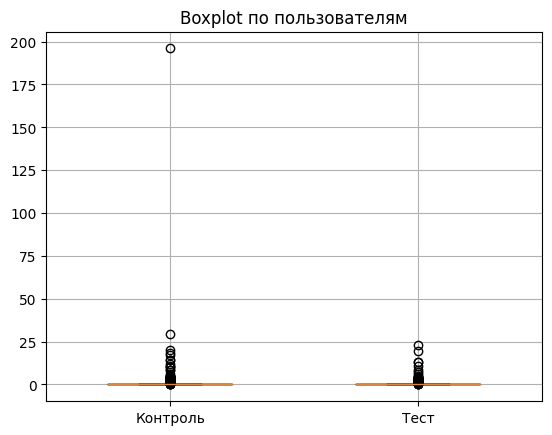

In [45]:
plt.boxplot([control.REVENUE, test.REVENUE],
            labels = ['Контроль', 'Тест'],
            widths = 0.5
            )
plt.title('Boxplot по пользователям', loc='center')
plt.grid(axis='both')

In [46]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

TtestResult(statistic=1.3996978409515475, pvalue=0.16172355638776942, df=2590.554714694372)

Мощность теста

In [47]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [49]:
n = len(control.REVENUE.values)

S = np.sqrt((T_std**2 +C_std**2)/2)

ef = float((C_mean-T_mean)/S)

In [50]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)

result

0.28803096229144043

В результате статистически значимой разницы между группами нет. Не имеет смысла внедрять данные изменения. Возможно был неудачно выбран тестируемый вариант, либо не та категория пользователей.